In [152]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import optuna
import joblib

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel, LightGBMModel, \
                        CatBoostModel, XGBModel,  BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from darts.dataprocessing.transformers import Scaler

from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor


from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [153]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [154]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['An Giang', 'BR Vũng Tàu']

In [155]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [156]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [157]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [158]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [159]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Dengue fever rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Dengue_fever_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [160]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [161]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [162]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y)

In [163]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    model.fit(y_train, past_covariates = x_train)

    prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

    df_eval_true_inverse = df_eval_pred_inverse = df_eval[-args.test_size:]
    y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))

    df_eval_pred_inverse[labels]= np.array(prediction._xa).squeeze()
    y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"mean_squared_error: {mse:.4f}")
    print(f"rmse: {rmse}")
    print(f"mape: {mape}")
    return model, y_true, y_pred, mse, mae, rmse, mape


In [164]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo,nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  "1-month": prediction_inverse})
    
    df_prediction["City"] = location
    df_prediction["RMSE_1-month"] = rmse
    df_prediction["MAE_1-month"] = mae
    df_prediction["MAPE_1-month"] = mape

    return mae

In [165]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv", encoding = 'unicode_escape')
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

# Objective and Suggest Hyperparams of Darts Models


In [166]:
def objective(model_name, trial, city, nstep):   
    specific_data = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
    scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

    df_train, df_valid = split_data(specific_data, args.look_back,nstep)

    selected_features = getDataWithSelectedFeature(city, nstep)

    lags_by_nstep = args.look_back + nstep - 1
    lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    is_dl_algo = 0

    pl_trainer_kwargs = {
              "accelerator": "cpu",
              # "devices": -1,
              # "auto_select_gpus": True,
          }

    if model_name == "RandomForest":
      random_state = trial.suggest_int('random_state', 0, 42)
      n_estimators = trial.suggest_int('n_estimators', 50, 200)
      max_depth = trial.suggest_int('max_depth', 1, 15)
      # Create the RandomForest model
      model = RandomForest(
                    lags = lags_by_nstep,
                    lags_past_covariates = lags_past_covariates_by_nstep,
                    output_chunk_length = 1,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    random_state=random_state)
    elif model_name == 'XGBModel':
      random_state = trial.suggest_int('random_state', 0, 43)
      likelihood = trial.suggest_categorical('likelihood', ['quantile'])
      # Create the  model
      model = XGBModel(
                      lags = lags_by_nstep,
                      lags_past_covariates = lags_past_covariates_by_nstep,
                      output_chunk_length = 1,
                      random_state=random_state,
                      likelihood = likelihood
                    )
    elif model_name == 'LinearRegressionModel':
      random_state = trial.suggest_int('random_state', 0, 43)
      # Create the  model
      model = LinearRegressionModel(
                      lags = lags_by_nstep,
                      lags_past_covariates = lags_past_covariates_by_nstep,
                      output_chunk_length = 1,
                      random_state=random_state)
    elif model_name == "CatBoostModel":
      #suggest hyperparams
      learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
      n_estimators = trial.suggest_int('n_estimators', 50, 200)
      max_depth = trial.suggest_int('max_depth', 1, 15)
      random_state = trial.suggest_int('random_state', 0, 1000)
      likelihood = trial.suggest_categorical('likelihood', ['quantile'])
      quantiles =  trial.suggest_categorical('quantiles', [None, [0.1, 0.5, 0.9]])
      bagging_temperature = trial.suggest_float('bagging_temperature', 0.01, 100.0)
      border_count = trial.suggest_int('border_count', 1, 255)
      l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.1, 10)
      random_strength = trial.suggest_float('random_strength', 0.1, 10)
      model = CatBoostModel(
                            lags=lags_by_nstep,
                            lags_past_covariates=lags_past_covariates_by_nstep, 
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            output_chunk_length = 1,
                            likelihood = likelihood,
                            quantiles = quantiles,
                            bagging_temperature = bagging_temperature,
                            border_count = border_count,
                            l2_leaf_reg = l2_leaf_reg,
                            random_strength = random_strength,
                            random_state=random_state)
    elif model_name == "LightGBMModel":
      params = {
        "lags": lags_by_nstep,
        "lags_past_covariates": lags_past_covariates_by_nstep,
        "random_state": trial.suggest_int("random_state", 0, 999),
        "multi_models": trial.suggest_categorical("multi_models", [True, False]),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'verbose': -1,
        'likelihood' : trial.suggest_categorical("likelihood", ["quantile"])
      }

      param = params
      model = LightGBMModel(
          lags = param['lags'],
          lags_past_covariates = param['lags_past_covariates'],
          output_chunk_length = 1,
          random_state = param['random_state'],
          multi_models = param['multi_models'],
          likelihood = param['likelihood'],
          num_leaves = param['num_leaves'],
          learning_rate = param['learning_rate'],
          feature_fraction = param['feature_fraction'],
          bagging_fraction = param['bagging_fraction'],
          min_child_samples = param['min_child_samples'],
          lambda_l1 = param['lambda_l1'],
          verbose = param['verbose']
      )
    elif model_name == "SVMRBF":
      random_state = trial.suggest_int('random_state', 0, 42)
      model = SVC(
          random_state = random_state,
          kernel = 'rbf',
          probability=True
      )
    elif model_name == "PoissonRegressor":
      max_iter = trial.suggest_int('max_iter', 50, 200)
      model = PoissonRegressor(
          max_iter = max_iter,
      )
    elif model_name == "BlockRNNModel":
      #suggest hyperparams
      random_state = trial.suggest_int('random_state', 0, 1000)
      n_rnn_layers = trial.suggest_int('n_rnn_layers', 1, 3)
      dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
      hidden_dim = trial.suggest_int('n_rnn_layers', 5, 20)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)

      model = BlockRNNModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          hidden_dim = hidden_dim,
                          n_rnn_layers = n_rnn_layers,
                          dropout = dropout,
                          n_epochs = n_epochs,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
      is_dl_algo = 1
    elif model_name == 'TFTModel':
      # Define the hyperparameters to optimize
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.8)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)

      # Create the TFTModel model
      model = TFTModel(
                    input_chunk_length = args.look_back,
                    output_chunk_length = args.n_predicted_period_months,
                    add_relative_index = True,
                    dropout = dropout,
                    n_epochs = n_epochs ,
                    random_state=random_state)
      is_dl_algo = 1
    elif model_name == 'NHiTSModel':
      #suggest hyperparams
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 100, 500, step=10)
      MaxPool1d = trial.suggest_categorical('MaxPool1d', [True, False])

      model = NHiTSModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          MaxPool1d = MaxPool1d,
                          dropout = dropout,
                          n_epochs = n_epochs ,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
      is_dl_algo = 1
    elif model_name == "NBEATSModel":
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)
      model = NBEATSModel(
                            input_chunk_length = args.look_back,
                            output_chunk_length = args.n_predicted_period_months,
                            dropout = dropout,
                            n_epochs = n_epochs ,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            random_state=random_state)
      is_dl_algo = 1
    elif model_name == "TCNModel":
      params = {
        'kernel_size': trial.suggest_int("kernel_size", 2, lags_by_nstep),
        'num_filters': trial.suggest_int("num_filters", 1, 5),
        'weight_norm': trial.suggest_categorical("weight_norm", [False, True]),
        'dilation_base': trial.suggest_int("dilation_base", 2, 4),
        'dropout': trial.suggest_float("dropout", 0.0, 0.4),
        'learning_rate': trial.suggest_float("learning_rate", 5e-5, 1e-3, log=True),
        'include_year': trial.suggest_categorical("year", [False, True]),
        'n_epochs': trial.suggest_int("n_epochs", 100, 300),
      }
      # select input and output chunk lengths
      params['input_chunk_length'] = args.look_back
      params['output_chunk_length'] = args.n_predicted_period_months  
      # optionally also add the (scaled) year value as a past covariate
      if params['include_year']:
          encoders = {"datetime_attribute": {"past": ["year"]},
                      "transformer": Scaler()}
      else:
          encoders = None
      params['encoders'] = encoders
      param = params
      model = TCNModel(
          input_chunk_length=param['input_chunk_length'],
          output_chunk_length=param['output_chunk_length'],
          batch_size=16,
          n_epochs=param['n_epochs'],
          nr_epochs_val_period=1,
          kernel_size=param['kernel_size'],
          num_filters=param['num_filters'],
          weight_norm=param['weight_norm'],
          dilation_base=param['dilation_base'],
          dropout=param['dropout'],
          optimizer_kwargs={"lr": param['learning_rate']},
          add_encoders=param['encoders'],
          likelihood=GaussianLikelihood(),
          pl_trainer_kwargs=pl_trainer_kwargs,
          model_name="tcn_model",
          force_reset=True,
          save_checkpoints=True,
      )
      is_dl_algo = 1
    
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo,nstep = nstep)

    return mae_error

# Main run optimize and save

[I 2023-10-28 02:27:41,238] A new study created in memory with name: CatBoostModel


⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  1
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


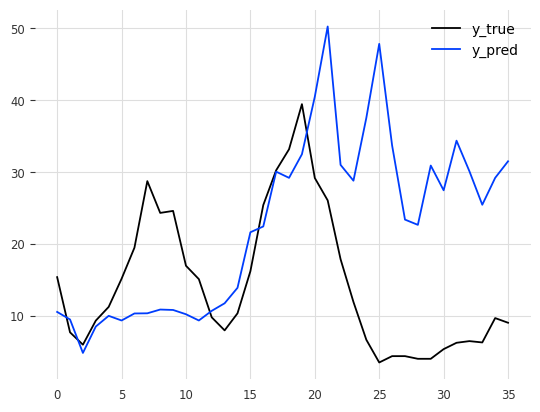

[I 2023-10-28 02:27:45,397] Trial 0 finished with value: 13.337311717850758 and parameters: {'learning_rate': 0.08501261492320672, 'n_estimators': 160, 'max_depth': 10, 'random_state': 312, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 27.80134111263545, 'border_count': 133, 'l2_leaf_reg': 6.145658907379587, 'random_strength': 2.1474049771976236}. Best is trial 0 with value: 13.337311717850758.
[I 2023-10-28 02:27:45,405] A new study created in memory with name: CatBoostModel


mean_squared_error: 292.5673
rmse: 17.104599160405712
mape: 1.9047662295463021
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


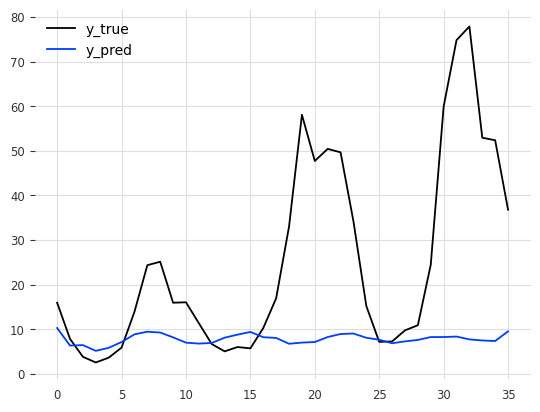

[I 2023-10-28 02:27:45,891] Trial 0 finished with value: 18.21710405327024 and parameters: {'learning_rate': 0.057445922304406136, 'n_estimators': 188, 'max_depth': 4, 'random_state': 878, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 43.46165423407379, 'border_count': 136, 'l2_leaf_reg': 2.233307707468917, 'random_strength': 5.788780793196336}. Best is trial 0 with value: 18.21710405327024.
[I 2023-10-28 02:27:45,901] A new study created in memory with name: CatBoostModel


mean_squared_error: 750.7554
rmse: 27.39991545960976
mape: 0.5683736003733982
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  2
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


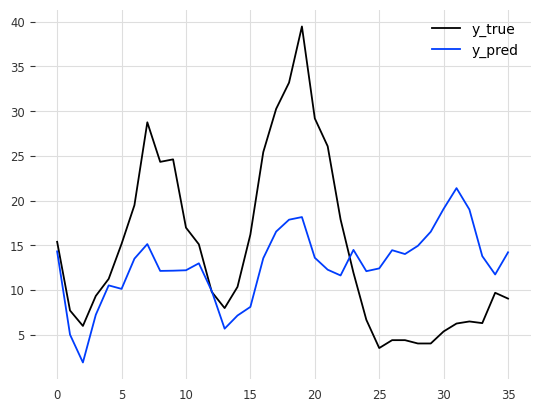

[I 2023-10-28 02:27:46,315] Trial 0 finished with value: 8.175766420905084 and parameters: {'learning_rate': 0.07179746444327503, 'n_estimators': 194, 'max_depth': 3, 'random_state': 310, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 71.27345226385518, 'border_count': 34, 'l2_leaf_reg': 5.27899624605672, 'random_strength': 5.9487137020233325}. Best is trial 0 with value: 8.175766420905084.
[I 2023-10-28 02:27:46,321] A new study created in memory with name: CatBoostModel


mean_squared_error: 95.0226
rmse: 9.747951452653226
mape: 0.8614554977002368
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


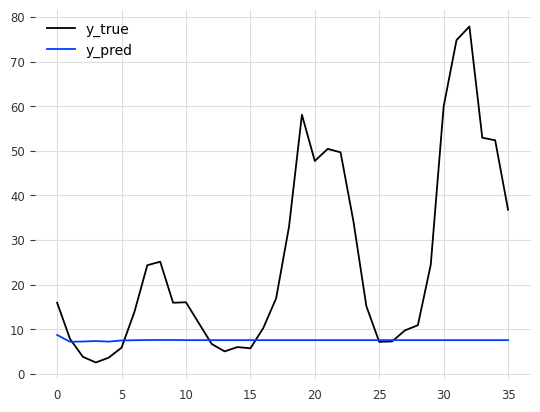

[I 2023-10-28 02:27:48,137] Trial 0 finished with value: 18.596835557800524 and parameters: {'learning_rate': 0.0061429713000733, 'n_estimators': 58, 'max_depth': 12, 'random_state': 639, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 41.933623579967126, 'border_count': 92, 'l2_leaf_reg': 4.942693608950858, 'random_strength': 9.942133016046904}. Best is trial 0 with value: 18.596835557800524.
[I 2023-10-28 02:27:48,145] A new study created in memory with name: CatBoostModel


mean_squared_error: 767.5965
rmse: 27.70553150381094
mape: 0.6061108982506638
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  3
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


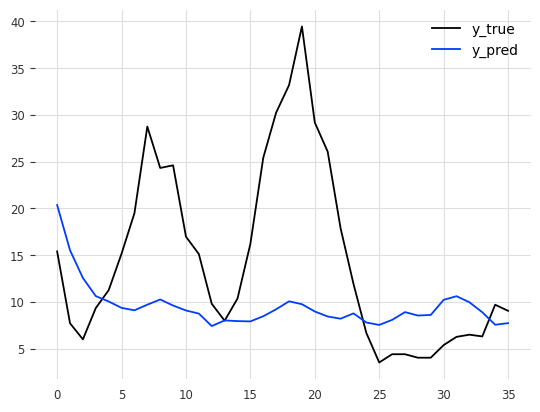

[I 2023-10-28 02:27:48,434] Trial 0 finished with value: 8.225449809878755 and parameters: {'learning_rate': 0.02564445941394587, 'n_estimators': 176, 'max_depth': 2, 'random_state': 131, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 49.96248596071857, 'border_count': 16, 'l2_leaf_reg': 5.481093897593701, 'random_strength': 4.404256794208708}. Best is trial 0 with value: 8.225449809878755.
[I 2023-10-28 02:27:48,440] A new study created in memory with name: CatBoostModel


mean_squared_error: 121.4490
rmse: 11.020389951984905
mape: 0.5723684938049751
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


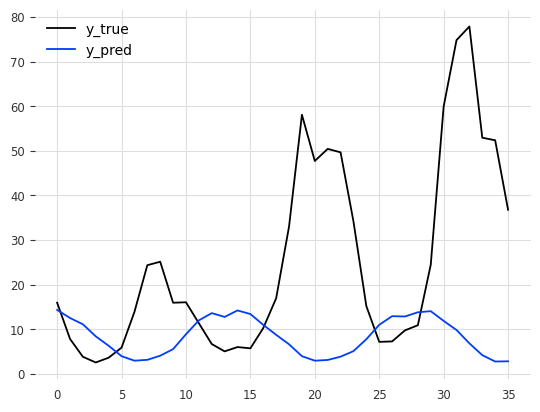

[I 2023-10-28 02:27:48,631] Trial 0 finished with value: 20.340518545023873 and parameters: {'learning_rate': 0.04690550827254259, 'n_estimators': 88, 'max_depth': 4, 'random_state': 85, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 82.67525224013795, 'border_count': 195, 'l2_leaf_reg': 4.672992944785083, 'random_strength': 2.268050161581442}. Best is trial 0 with value: 20.340518545023873.
[I 2023-10-28 02:27:48,632] A new study created in memory with name: CatBoostModel


mean_squared_error: 839.3728
rmse: 28.97193086076074
mape: 0.8067008956019899
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  4
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


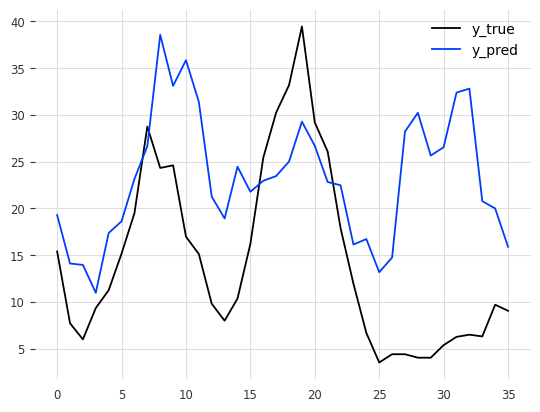

[I 2023-10-28 02:27:50,896] Trial 0 finished with value: 10.671752615093071 and parameters: {'learning_rate': 0.04932314195431083, 'n_estimators': 90, 'max_depth': 9, 'random_state': 762, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 99.39535157636512, 'border_count': 150, 'l2_leaf_reg': 0.8112220710990795, 'random_strength': 5.045214665214241}. Best is trial 0 with value: 10.671752615093071.
[I 2023-10-28 02:27:50,903] A new study created in memory with name: CatBoostModel


mean_squared_error: 168.0924
rmse: 12.965044979912982
mape: 1.4633071725598987
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


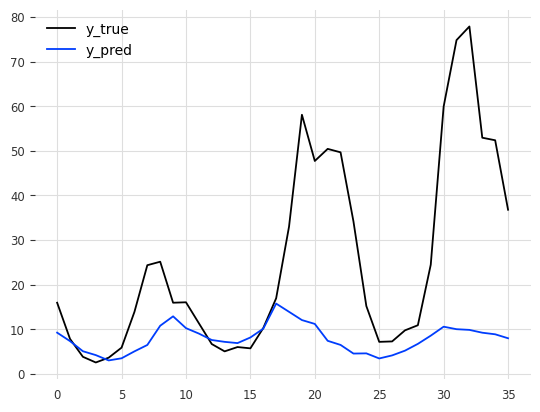

[I 2023-10-28 02:27:51,552] Trial 0 finished with value: 17.52556795282445 and parameters: {'learning_rate': 0.06442594626257568, 'n_estimators': 142, 'max_depth': 7, 'random_state': 78, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 25.336672795798147, 'border_count': 31, 'l2_leaf_reg': 8.380104429400088, 'random_strength': 7.3781503484341995}. Best is trial 0 with value: 17.52556795282445.
[I 2023-10-28 02:27:51,559] A new study created in memory with name: CatBoostModel


mean_squared_error: 707.2548
rmse: 26.594262066327627
mape: 0.5232300273483018
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  5
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


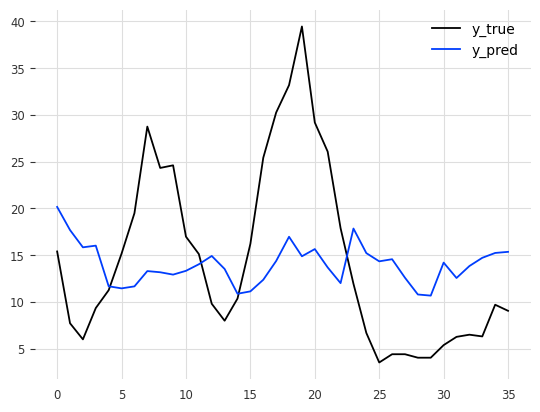

[I 2023-10-28 02:27:53,454] Trial 0 finished with value: 8.437443022839481 and parameters: {'learning_rate': 0.05023903015998089, 'n_estimators': 136, 'max_depth': 13, 'random_state': 489, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 88.90127512499132, 'border_count': 19, 'l2_leaf_reg': 6.554003869804311, 'random_strength': 0.6582708263861603}. Best is trial 0 with value: 8.437443022839481.
[I 2023-10-28 02:27:53,454] A new study created in memory with name: CatBoostModel


mean_squared_error: 94.2826
rmse: 9.709920616415724
mape: 0.8352135286920793
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


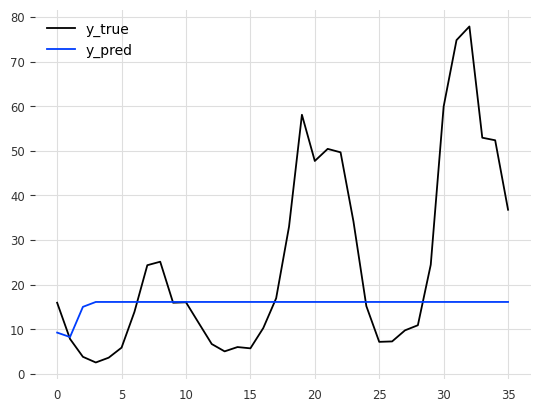

[I 2023-10-28 02:27:54,162] Trial 0 finished with value: 16.664832956509724 and parameters: {'learning_rate': 0.052345412891550064, 'n_estimators': 179, 'max_depth': 10, 'random_state': 4, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 5.507821114868852, 'border_count': 5, 'l2_leaf_reg': 1.5364094800861268, 'random_strength': 4.790629858553655}. Best is trial 0 with value: 16.664832956509724.
[I 2023-10-28 02:27:54,169] A new study created in memory with name: CatBoostModel


mean_squared_error: 541.6781
rmse: 23.273979070807663
mape: 0.9727874441851083
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  6
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


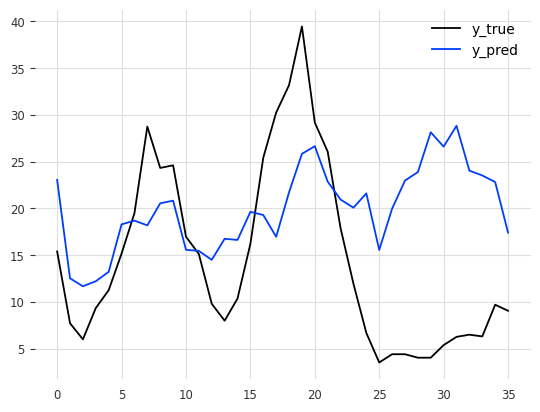

[I 2023-10-28 02:27:55,951] Trial 0 finished with value: 9.346137618667731 and parameters: {'learning_rate': 0.033196535105980876, 'n_estimators': 88, 'max_depth': 12, 'random_state': 555, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 7.718709314149476, 'border_count': 78, 'l2_leaf_reg': 6.315501199128254, 'random_strength': 9.323045227527155}. Best is trial 0 with value: 9.346137618667731.
[I 2023-10-28 02:27:55,951] A new study created in memory with name: CatBoostModel


mean_squared_error: 133.0272
rmse: 11.533743600072615
mape: 1.3305729171951561
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


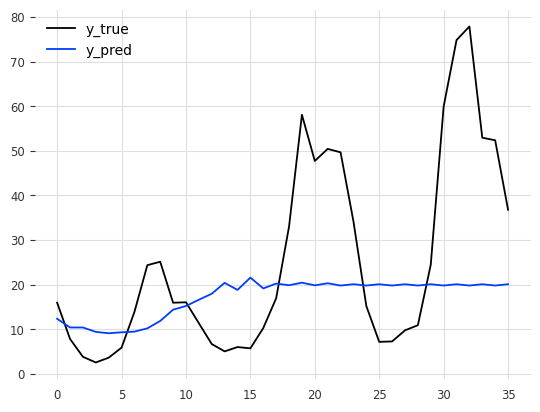

[I 2023-10-28 02:27:57,365] Trial 0 finished with value: 16.02895695608158 and parameters: {'learning_rate': 0.01173801857890596, 'n_estimators': 196, 'max_depth': 7, 'random_state': 859, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 47.70691376401745, 'border_count': 239, 'l2_leaf_reg': 3.0245266325154536, 'random_strength': 6.751630115864389}. Best is trial 0 with value: 16.02895695608158.


mean_squared_error: 465.6497
rmse: 21.578918270316002
mape: 0.9111990899503599
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu


In [167]:
#########################
# Main cell for optimize ML algorithm
#########################
# Hai thuật toán này chưa chạy đc nhe, nên đừng truyền vô mảng để nó chạy nhoé!
# "PoissonRegressor"
# "SVMRBF"

model_name_list = [
    #  "RandomForest",
    #  "LinearRegressionModel",
    #  "LightGBMModel",
     "CatBoostModel",
    #  "XGBModel",
    
]


# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]

if __name__ == '__main__':
  for nstep in range(1,args.n_predicted_period_months+1):
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep: ",nstep)
    lags_by_nstep = args.look_back + nstep - 1
    lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    lags_past_covariates_in_str = str(-lags_by_nstep+2)+","+str(-lags_by_nstep+1)+","+str(-lags_by_nstep)
    for model_name in model_name_list: 
      print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name: ",model_name)
      best_param = pd.DataFrame()
      for city_index in range(len(cities)):
        print("⭐️⭐️ City: ",cities[city_index])
        # Use Tree-structured Parzen Estimator sampler to minimise RMSE
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize', study_name = model_name)
        # truyền multiple param vào trong biến trial
        obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
        try:
          # Optimise over 100 trials
          study.optimize(obj_func, n_trials=args.ntry, n_jobs=args.njob)

          # Print results
          print("Study statistics for : ")
          print("  Number of finished trials: ", len(study.trials))
          print("Best trial of city: ",cities[city_index])

          best_trial = study.best_trial
          # lưu best param vào trong biến toàn cục

          if model_name == "LinearRegressionModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'LinearRegressionModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'random_state':best_trial.params['random_state'],
                                })
          elif model_name == 'XGBModel':
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'XGBModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'random_state':best_trial.params['random_state'],
                                'likelihood': best_trial.params['likelihood'],
                                })
          elif model_name == "LightGBMModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'LightGBMModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags': lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'multi_models': best_trial.params['multi_models'],
                                'num_leaves': best_trial.params['num_leaves'], 
                                'feature_fraction': best_trial.params['feature_fraction'], 
                                'min_child_samples': best_trial.params['min_child_samples'], 
                                'lambda_l1': best_trial.params['lambda_l1'], 
                                'lambda_l2': best_trial.params['lambda_l2'], 
                                'likelihood': best_trial.params['likelihood'], 
                                'learning_rate': best_trial.params['learning_rate']
                                })
          elif model_name == "CatBoostModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'CatBoost',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'learning_rate': best_trial.params['learning_rate'],
                                'n_estimators': best_trial.params['n_estimators'],
                                'max_depth': best_trial.params['max_depth'],
                                'random_state': best_trial.params['random_state'],
                                'likelihood': best_trial.params['likelihood'],
                                'quantiles': best_trial.params['quantiles'],
                                'bagging_temperature': best_trial.params['bagging_temperature'],
                                'border_count': best_trial.params['border_count'],
                                'l2_leaf_reg': best_trial.params['l2_leaf_reg'],
                                'random_strength':best_trial.params['random_strength'],
                                })
          elif model_name == "RandomForest":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'n_estimators': best_trial.params['n_estimators'],
                                'max_depth': best_trial.params['max_depth'],
                                'random_state':best_trial.params['random_state'],
                                })
          elif model_name == "SVMRBF":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'random_state':best_trial.params['random_state'],
                                'kernel': 'rbf',
                                'probability': True,
                                })
          elif model_name == "PoissonRegressor":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'max_iter':best_trial.params['max_iter'],
                                })
          # file_path = 'opt_results/opt_res_ml_26102023/261023_DF_opt_hyperparam_'+ model_name + '_'+str(nstep)+'-nstep.xlsx'
          folder_path = f'opt_results/opt_res_ml_26102023/{model_name}/'
          file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
          if(os.path.isfile(file_path)):
              with pd.ExcelWriter(file_path,mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
                  one_city_param.to_excel(writer, header=None, startrow=city_index+1,index=False)
          else:
              if(not (os.path.isdir(folder_path))):
                os.mkdir(folder_path)
              with pd.ExcelWriter(file_path,engine="openpyxl") as writer:
                  one_city_param.to_excel(writer, startrow=city_index,index=False)
        except:# có error thì lưu vào l_errCity để check lại sau 
          l_errCity.append(cities[city_index])
          #send_to_telegram(f'Tỉnh bị lỗi trong quá trình optimize bằng model {model_name}: {cities[city_index]}')

In [168]:
# send_to_telegram("Chạy xong optimize rùiii!!Vô check thuiii!!!" )